<a href="https://colab.research.google.com/github/song-pongpanit/radon_us/blob/main/radon_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 3.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
import kerastuner as kt

Using TensorFlow backend


<ipython-input-2-3f582fc2953a>:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


# Import data

In [3]:
radon, info = tfds.load('radon', with_info=True, split='train')
df = tfds.as_dataframe(radon, info)
df.rename(columns=lambda x: x.replace('features/', ''), inplace=True)
df.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12573 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/radon/1.0.0.incomplete0O5TBG/radon-train.tfrecord*...:   0%|          | 0/…

Dataset radon downloaded and prepared to /root/tensorflow_datasets/radon/1.0.0. Subsequent calls will reuse this data.


activity     Uppm       adjwt basement  cntyfips                   county  \
0       1.6  2.49759  292.219543     b'N'         3  b'ALLEN               '   
1       0.5  2.66527  364.958313     b'N'        25  b'YAVAPAI             '   
2       3.0  2.43343  626.564575     b'Y'        17  b'MIDDLESEX           '   
3       0.6  2.43343  570.611755     b'N'        17  b'MIDDLESEX           '   
4       1.2  2.10811  426.798859     b'Y'        95  b'JACKSON             '   

   dupflag  floor  idnum        lat  ...  state2  stfips  stopdt  stoptm  \
0        0      1   1681  41.091000  ...   b'IN'      18   11689    2235   
1        0      1   1457  34.599998  ...   b'AZ'       4   22888    1010   
2        0      0   4224  42.485001  ...   b'MA'      25   32488    1000   
3        0      1   4094  42.485001  ...   b'MA'      25   32688    1200   
4        0      0   6849  39.007999  ...   b'MO'      29   32488     610   

   stratum  typebldg  wave windoor    zip  zipflag  
0        2         1    92    b' '  46835        0  
1        2         1    56    b' '  86325        0  
2        1         1    23    b' '   1778        0  
3        1         1    62    b' '   1432        0  
4        2         1    91    b' '  64134        0  

[5 rows x 28 columns]

In [4]:
df.shape

(12573, 28)

In [5]:
df.info()

<class 'tensorflow_datasets.core.as_dataframe.as_dataframe.<locals>.StyledDataFrame'>
RangeIndex: 12573 entries, 0 to 12572
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  12573 non-null  float32
 1   Uppm      12573 non-null  float32
 2   adjwt     12573 non-null  float32
 3   basement  12573 non-null  object 
 4   cntyfips  12573 non-null  int32  
 5   county    12573 non-null  object 
 6   dupflag   12573 non-null  int32  
 7   floor     12573 non-null  int32  
 8   idnum     12573 non-null  int32  
 9   lat       12573 non-null  float32
 10  lon       12573 non-null  float32
 11  pcterr    12573 non-null  float32
 12  region    12573 non-null  int32  
 13  rep       12573 non-null  int32  
 14  room      12573 non-null  int32  
 15  startdt   12573 non-null  int32  
 16  starttm   12573 non-null  int32  
 17  state     12573 non-null  object 
 18  state2    12573 non-null  object 
 19  stfips    12573 non

# Data Preparation

## Filter state in US

In [6]:
df['state'] = df['state'].astype(str).str.extract(r'b\' *(\w+) *\'')
df['state2'] = df['state2'].astype(str).str.extract(r'b\' *(\w+) *\'')
df['county'] = df['county'].astype(str).str.extract(r'b\' *(\w+) *\'')

In [7]:
df[['state']].value_counts()

state
PA       2389
IN       1914
MO       1859
MA       1659
ND       1596
AZ       1507
MN        919
R5        730
dtype: int64

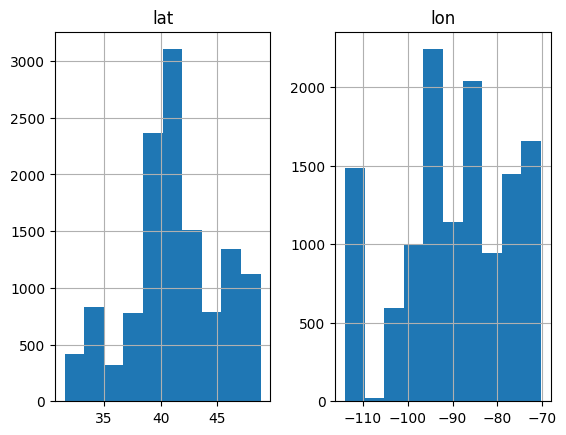

In [8]:
df[['lat', 'lon']].hist()
plt.show()

In [9]:
# drop useless columns
df = df.drop(columns=['state2', 'stfips', 'zip', 'region', 'cntyfips', 'idnum', 'county', 'state'])

## aggegrate total time

In [10]:
df[['startdt', 'starttm', 'stopdt', 'stoptm']].head()

startdt  starttm  stopdt  stoptm
0    11489     2230   11689    2235
1    22688      833   22888    1010
2    32288     1000   32488    1000
3    32488      700   32688    1200
4    32288      605   32488     610

In [11]:
df['startdt'] = df['startdt'].astype(str).apply(lambda x : '0' + x if len(x) < 6 else x)
df['stopdt'] = df['stopdt'].astype(str).apply(lambda x : '0' + x if len(x) < 6 else x)
df['starttm'] = df['starttm'].astype(str).apply(lambda x : '0' + x if len(x) < 4 else x)
df['stoptm'] = df['stoptm'].astype(str).apply(lambda x : '0' + x if len(x) < 4 else x)

df['start_dttm'] = df['startdt'] + df['starttm']
df['stop_dttm'] = df['stopdt'] + df['stoptm']

df[['startdt', 'starttm', 'stopdt', 'stoptm', 'start_dttm', 'stop_dttm']].head()

startdt starttm  stopdt stoptm  start_dttm   stop_dttm
0  011489    2230  011689   2235  0114892230  0116892235
1  022688    0833  022888   1010  0226880833  0228881010
2  032288    1000  032488   1000  0322881000  0324881000
3  032488    0700  032688   1200  0324880700  0326881200
4  032288    0605  032488   0610  0322880605  0324880610

In [12]:
df['start_dttm'] = pd.to_datetime(df['start_dttm'], format='%m%d%y%H%M')
df['stop_dttm'] = pd.to_datetime(df['stop_dttm'], format='%m%d%y%H%M')

df[['startdt', 'starttm', 'stopdt', 'stoptm', 'start_dttm', 'stop_dttm']].head()

startdt starttm  stopdt stoptm          start_dttm           stop_dttm
0  011489    2230  011689   2235 1989-01-14 22:30:00 1989-01-16 22:35:00
1  022688    0833  022888   1010 1988-02-26 08:33:00 1988-02-28 10:10:00
2  032288    1000  032488   1000 1988-03-22 10:00:00 1988-03-24 10:00:00
3  032488    0700  032688   1200 1988-03-24 07:00:00 1988-03-26 12:00:00
4  032288    0605  032488   0610 1988-03-22 06:05:00 1988-03-24 06:10:00

In [13]:
df[(df['start_dttm'] == df['stop_dttm'])][['startdt', 'starttm', 'stopdt', 'stoptm', 'start_dttm', 'stop_dttm']]

startdt starttm  stopdt stoptm          start_dttm           stop_dttm
16     120287    1700  120287   1700 1987-12-02 17:00:00 1987-12-02 17:00:00
48     120288    1000  120288   1000 1988-12-02 10:00:00 1988-12-02 10:00:00
62     030388    1200  030388   1200 1988-03-03 12:00:00 1988-03-03 12:00:00
82     030388    1930  030388   1930 1988-03-03 19:30:00 1988-03-03 19:30:00
88     030388    1800  030388   1800 1988-03-03 18:00:00 1988-03-03 18:00:00
...       ...     ...     ...    ...                 ...                 ...
12491  030388    1730  030388   1730 1988-03-03 17:30:00 1988-03-03 17:30:00
12492  030389    2030  030389   2030 1989-03-03 20:30:00 1989-03-03 20:30:00
12531  040488    0900  040488   0900 1988-04-04 09:00:00 1988-04-04 09:00:00
12555  040488    2200  040488   2200 1988-04-04 22:00:00 1988-04-04 22:00:00
12559  120288    2030  120288   2030 1988-12-02 20:30:00 1988-12-02 20:30:00

[1352 rows x 6 columns]

In [14]:
df['totaltm'] = abs(df['stop_dttm'] - df['start_dttm'])
df['totaltm'] = df['totaltm'].apply(lambda x : x.total_seconds()/ (60)).astype('float32')

df[['startdt', 'starttm', 'stopdt', 'stoptm', 'start_dttm', 'stop_dttm','totaltm']].head()

startdt starttm  stopdt stoptm          start_dttm           stop_dttm  \
0  011489    2230  011689   2235 1989-01-14 22:30:00 1989-01-16 22:35:00   
1  022688    0833  022888   1010 1988-02-26 08:33:00 1988-02-28 10:10:00   
2  032288    1000  032488   1000 1988-03-22 10:00:00 1988-03-24 10:00:00   
3  032488    0700  032688   1200 1988-03-24 07:00:00 1988-03-26 12:00:00   
4  032288    0605  032488   0610 1988-03-22 06:05:00 1988-03-24 06:10:00   

   totaltm  
0   2885.0  
1   2977.0  
2   2880.0  
3   3180.0  
4   2885.0

<Axes: xlabel='totaltm', ylabel='activity'>

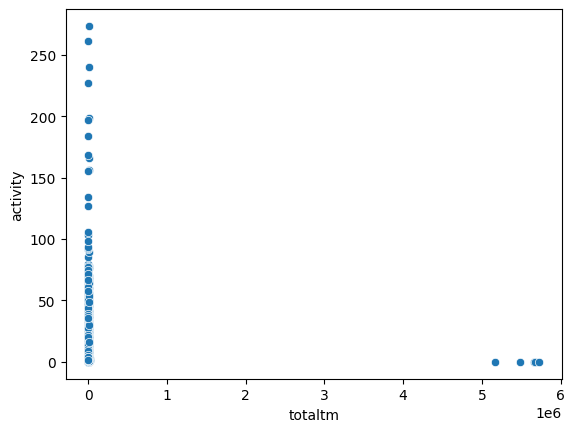

In [15]:
sns.scatterplot(data=df, x='totaltm', y='activity')

In [16]:
df = df.drop(columns=['startdt', 'starttm', 'stopdt', 'stoptm', 'start_dttm', 'stop_dttm', 'totaltm'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12573 entries, 0 to 12572
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  12573 non-null  float32
 1   Uppm      12573 non-null  float32
 2   adjwt     12573 non-null  float32
 3   basement  12573 non-null  object 
 4   dupflag   12573 non-null  int32  
 5   floor     12573 non-null  int32  
 6   lat       12573 non-null  float32
 7   lon       12573 non-null  float32
 8   pcterr    12573 non-null  float32
 9   rep       12573 non-null  int32  
 10  room      12573 non-null  int32  
 11  stratum   12573 non-null  int32  
 12  typebldg  12573 non-null  int32  
 13  wave      12573 non-null  int32  
 14  windoor   12573 non-null  object 
 15  zipflag   12573 non-null  int32  
dtypes: float32(6), int32(8), object(2)
memory usage: 884.2+ KB


## activity(target)

In [17]:
num_fac = df[['activity', 'Uppm', 'adjwt', 'pcterr', 'rep', 'stratum', 'wave']]
num_fac.describe()

activity          Uppm         adjwt        pcterr           rep  \
count  12573.000000  12573.000000  12573.000000  12573.000000  12573.000000   
mean       4.460781      1.974840    549.680115     13.376051      2.776028   
std        9.239971      0.726788    441.200043     13.274920      1.662104   
min        0.000000      0.000000      2.081602      0.000000     -1.000000   
25%        1.100000      1.619770    288.889313      5.100000      2.000000   
50%        2.200000      2.007850    443.843689      9.800000      3.000000   
75%        4.800000      2.433430    710.826416     18.299999      4.000000   
max      273.500000      3.767130   2364.762695    490.399994      5.000000   

            stratum          wave  
count  12573.000000  12573.000000  
mean       3.170126     55.599539  
std        3.625495     34.132766  
min        1.000000     -1.000000  
25%        1.000000     31.000000  
50%        2.000000     53.000000  
75%        4.000000     81.000000  
max       29.000000    140.000000

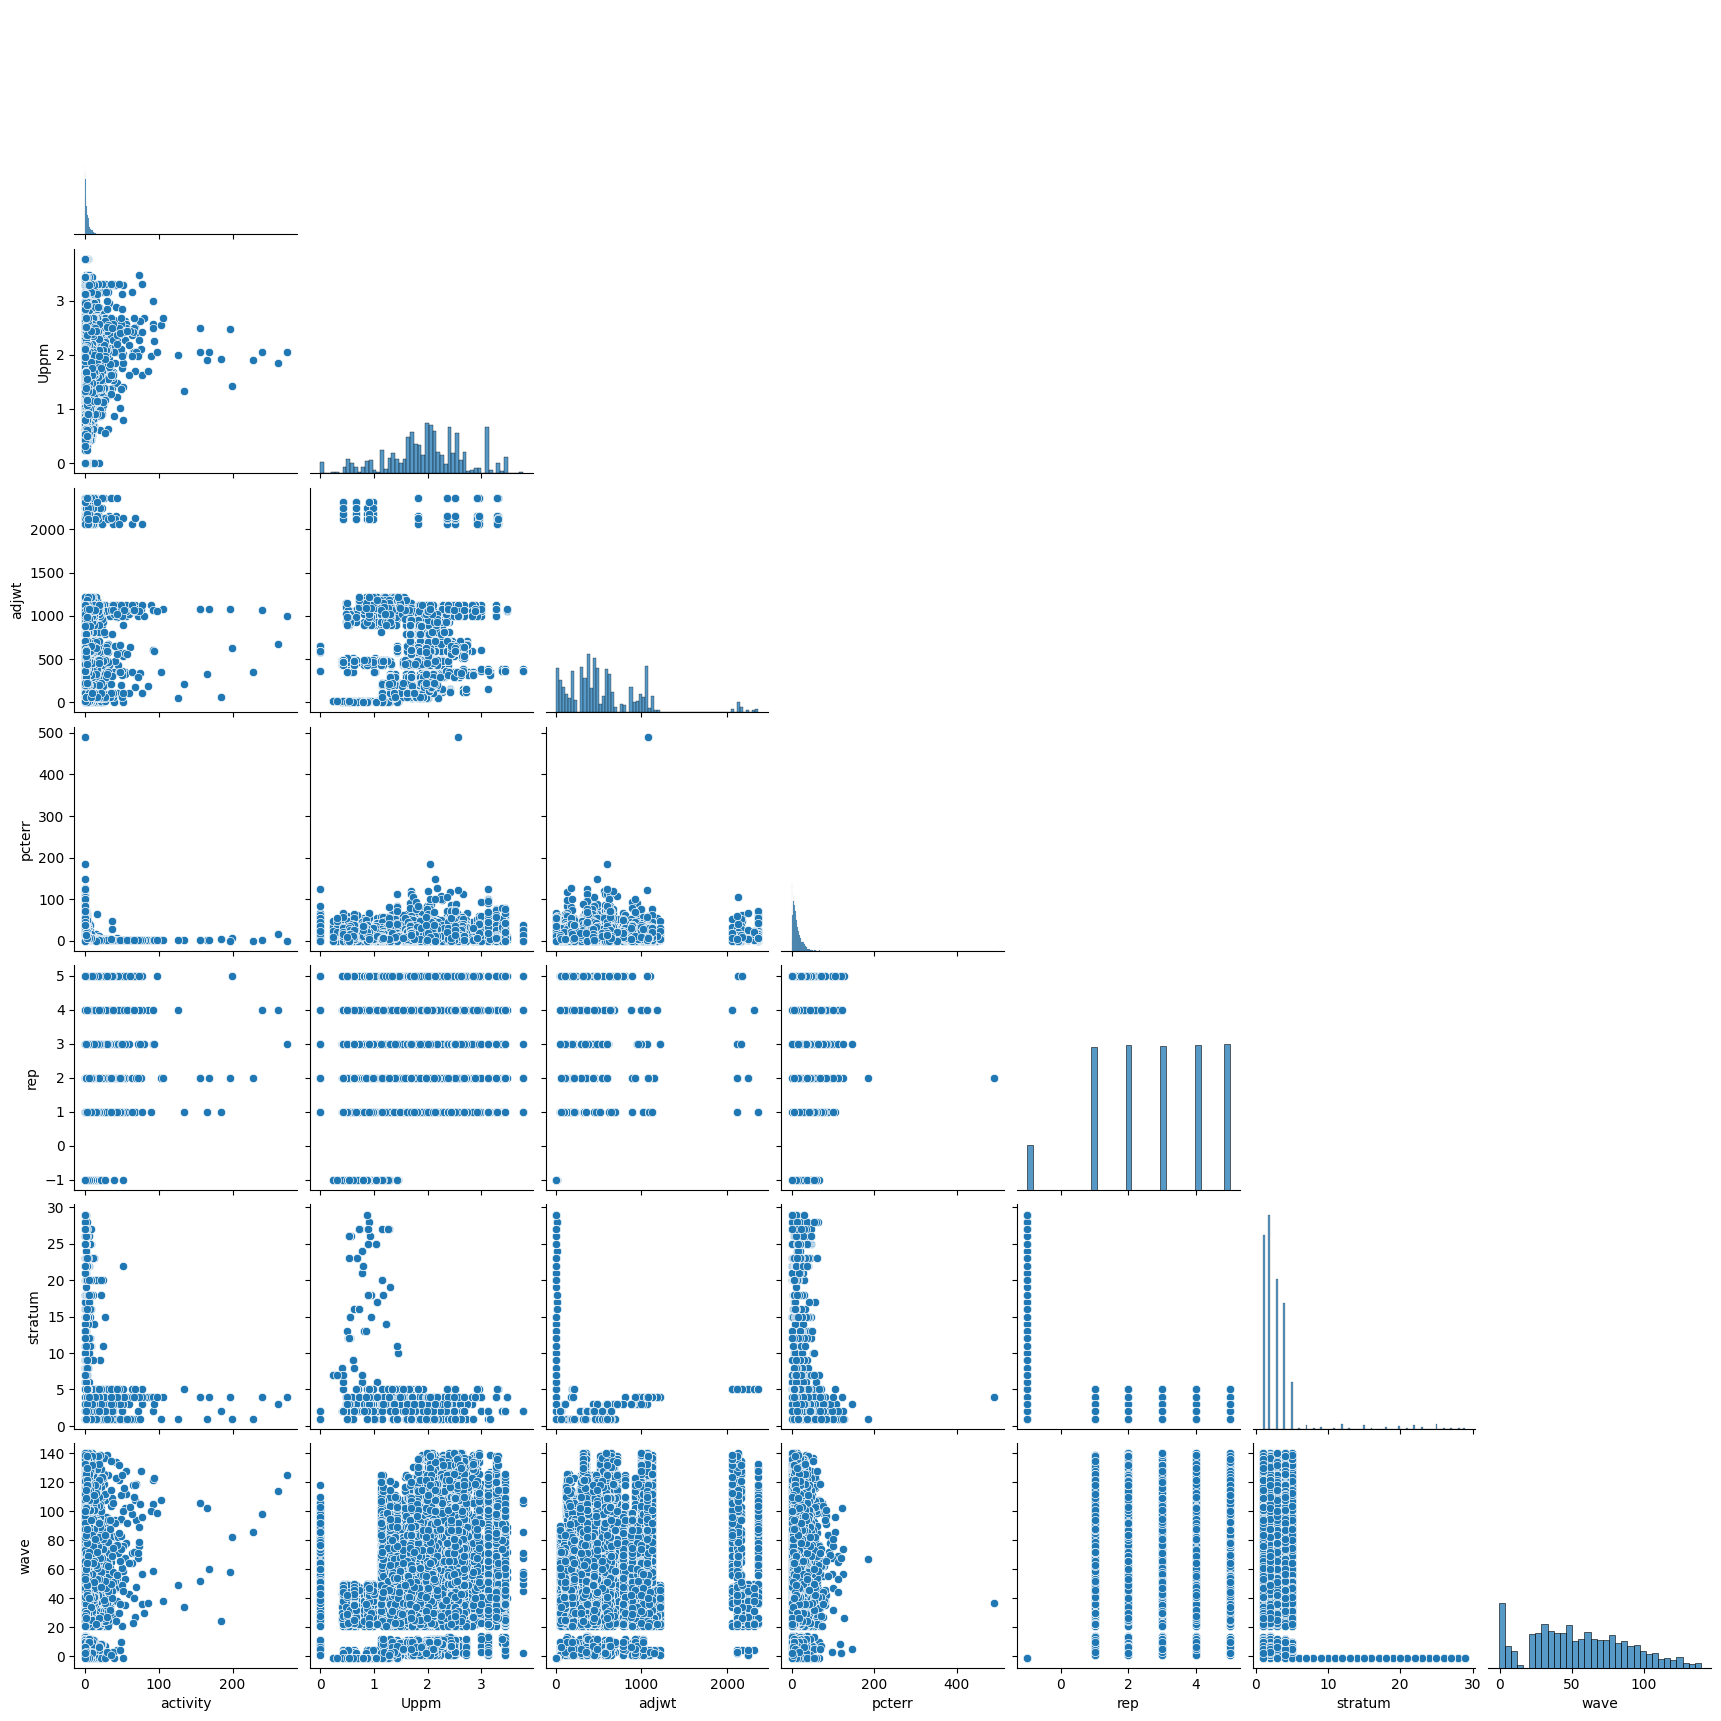

In [18]:
sns.pairplot(num_fac, corner=True)
plt.show()

In [19]:
def clean_outliers(data,column) :
    seventy_fifth = data[column].quantile(0.75)
    twenty_fifth = data[column].quantile(0.25)
    iqr = seventy_fifth - twenty_fifth
    upper = seventy_fifth + (1.5 * iqr)
    lower = twenty_fifth - (1.5 * iqr)
    data_clean = data[ (data[column] > lower) & (data[column] < upper) ]
    return data_clean

def dist_plot(data, col) :
  plt.figure(figsize=(15,3))
  plt.subplot(1,2,1)
  plt.title('Boxplot of ' + str(col))
  sns.boxplot( data=data, x=col)
  plt.subplot(1,2,2)
  plt.title('Histogram of ' + str(col))
  sns.histplot(data=data, x=col)
  plt.show()

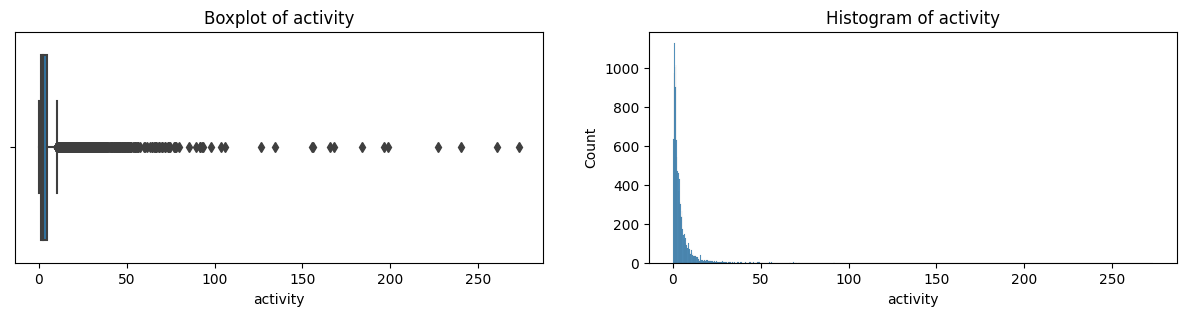

In [20]:
dist_plot(df, 'activity')

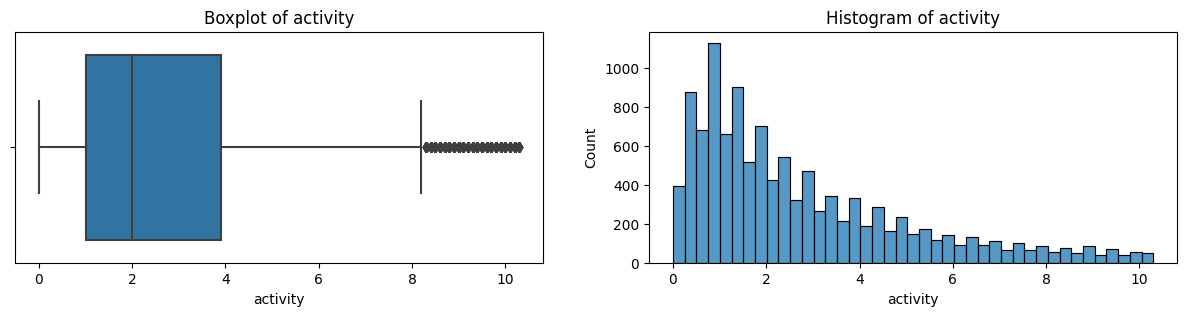

In [21]:
df = clean_outliers(df,'activity')
dist_plot(df, 'activity')

## rep, wave

In [22]:
df = df[(df['rep'] != -1) | (df['wave'] != -1)]
df.shape

(10793, 16)

## Uppm

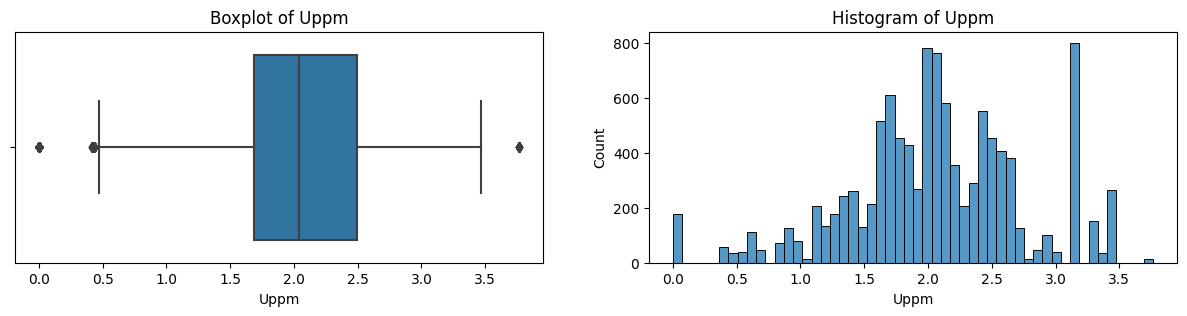

In [23]:
dist_plot(df, 'Uppm')

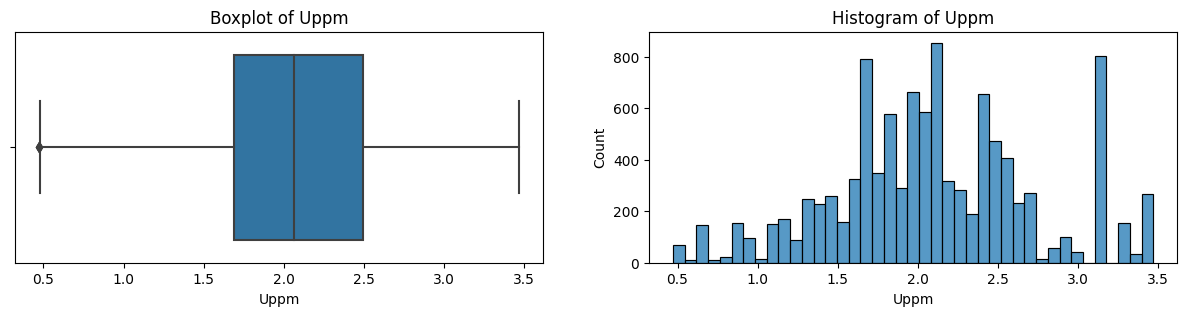

In [24]:
df = clean_outliers(df,'Uppm')
dist_plot(df, 'Uppm')

## adjwt

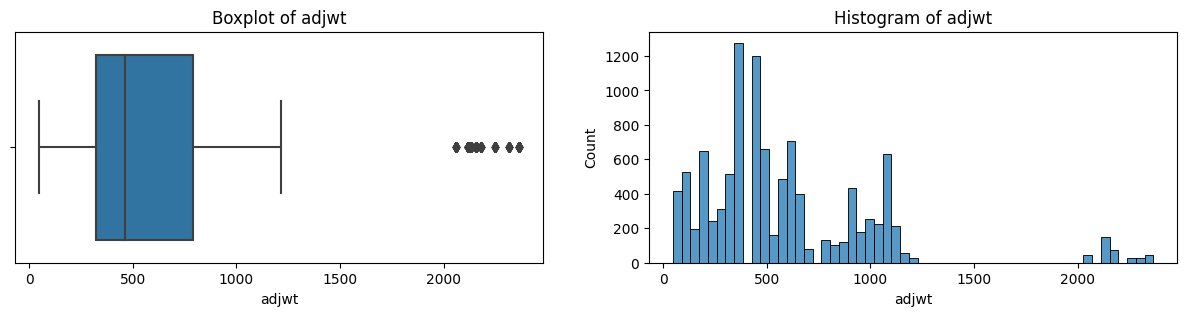

In [25]:
dist_plot(df, 'adjwt')

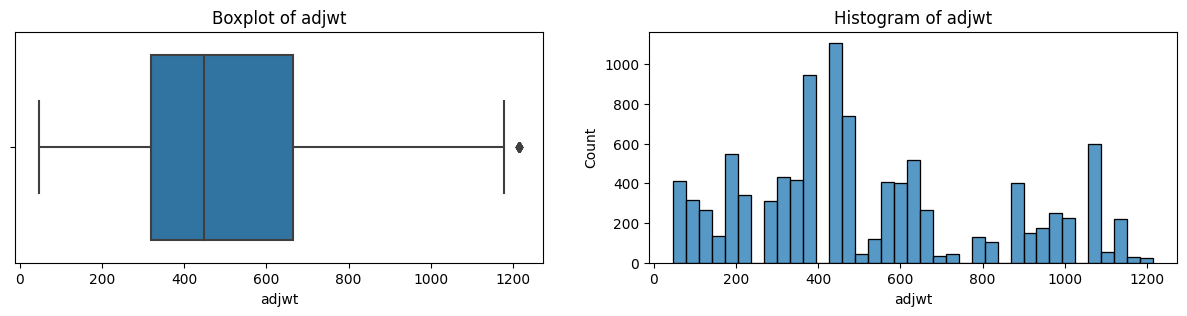

In [26]:
df = clean_outliers(df,'adjwt')
dist_plot(df, 'adjwt')

## pcterr

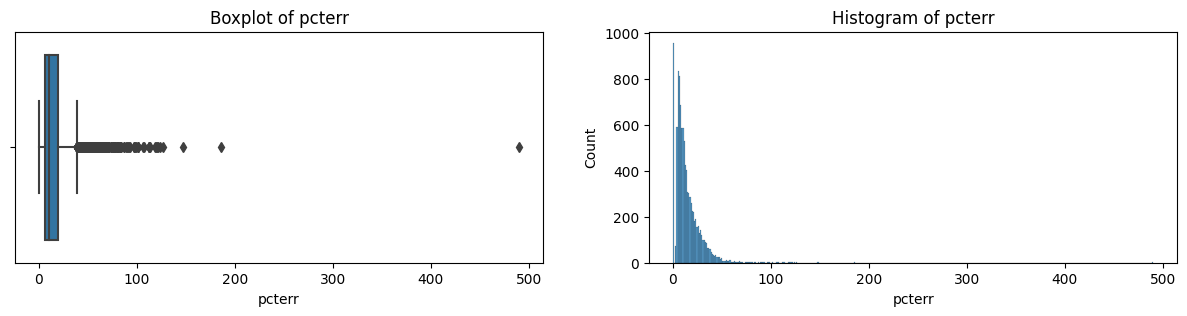

In [27]:
dist_plot(df, 'pcterr')

In [28]:
# df = df.drop(columns='pcterr')

## windoor

In [29]:
cate_fac = ['windoor', 'basement', 'dupflag', 'zipflag', 'room', 'floor', 'typebldg']

for col in cate_fac:
    print('column : ', col)
    print(df[col].value_counts())
    print('-'*50)

column :  windoor
b' '    10179
Name: windoor, dtype: int64
--------------------------------------------------
column :  basement
b'Y'    6576
b'N'    2961
b' '     575
b'0'      67
Name: basement, dtype: int64
--------------------------------------------------
column :  dupflag
0    9802
1     352
2      25
Name: dupflag, dtype: int64
--------------------------------------------------
column :  zipflag
0    10173
1        6
Name: zipflag, dtype: int64
--------------------------------------------------
column :  room
4    3756
2    1748
3    1477
1    1297
0    1002
7     803
5      94
6       2
Name: room, dtype: int64
--------------------------------------------------
column :  floor
0    6411
1    3477
9     253
2      20
3      18
Name: floor, dtype: int64
--------------------------------------------------
column :  typebldg
1    9147
0     532
2     361
5     131
3       8
Name: typebldg, dtype: int64
--------------------------------------------------


In [30]:
df = df.drop(columns='windoor')

## basement

In [31]:
df['basement'] = df['basement'].astype(str).str.replace('b\'0\'', 'b\'N\'', regex=True)
df['basement'] = df['basement'].astype(str).str.replace('b\' \'', 'b\'U\'', regex=True)
df['basement'] = df['basement'].astype(str).str.extract(r'b\'(\w+)\'')
df['basement'].value_counts()

Y    6576
N    3028
U     575
Name: basement, dtype: int64

[]

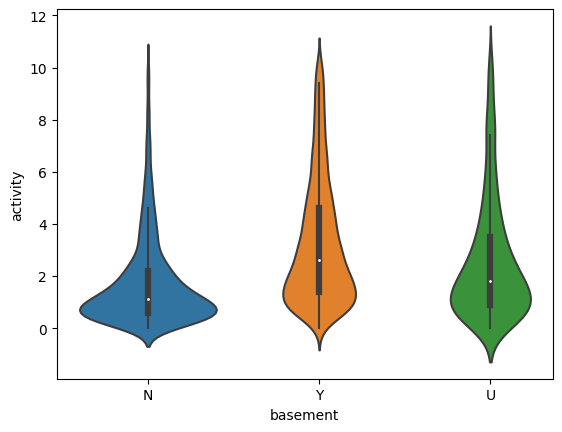

In [32]:
sns.violinplot(data=df, x='basement', y='activity')
plt.plot()

## dupflag

In [33]:
df['dupflag'].value_counts()

0    9802
1     352
2      25
Name: dupflag, dtype: int64

In [34]:
df['dupflag'].replace(2, 1, inplace=True)
df['dupflag'].value_counts()

0    9802
1     377
Name: dupflag, dtype: int64

[]

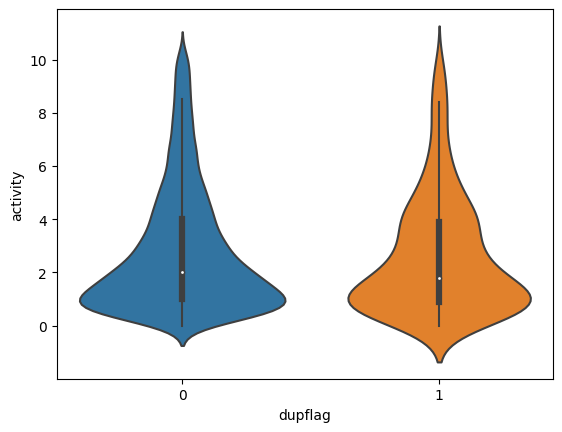

In [35]:
sns.violinplot(data=df, x='dupflag', y='activity')
plt.plot()

## zipflag

In [36]:
df['zipflag'].value_counts()

0    10173
1        6
Name: zipflag, dtype: int64

In [37]:
df = df.drop(columns='zipflag')

## room

In [38]:
df['room'].value_counts()

4    3756
2    1748
3    1477
1    1297
0    1002
7     803
5      94
6       2
Name: room, dtype: int64

[]

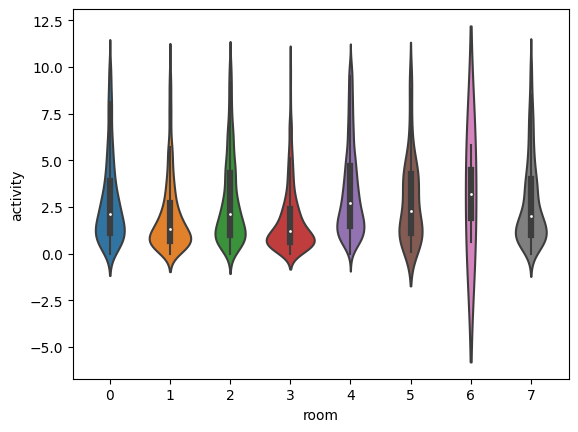

In [39]:
sns.violinplot(data=df, x='room', y='activity')
plt.plot()

## floor

In [40]:
# df['floor'].value_counts()
# print('-'*50)
df['floor'].replace(3, 2, inplace=True)
df['floor'].value_counts()

0    6411
1    3477
9     253
2      38
Name: floor, dtype: int64

[]

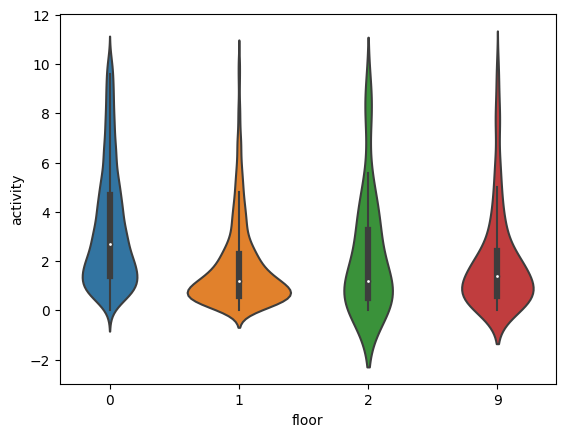

In [41]:
sns.violinplot(data=df, x='floor', y='activity')
plt.plot()

## typebldg

In [42]:
df['typebldg'].value_counts()

1    9147
0     532
2     361
5     131
3       8
Name: typebldg, dtype: int64

[]

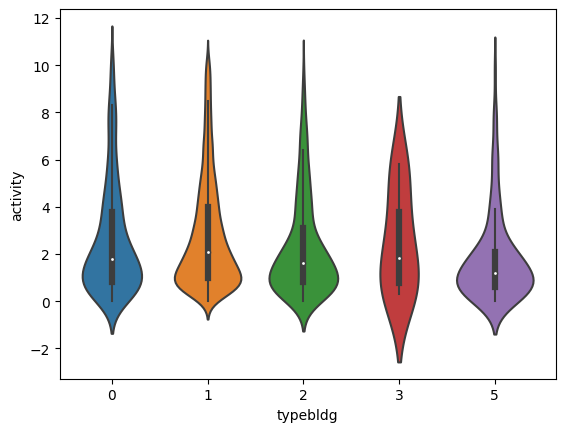

In [43]:
sns.violinplot(data=df, x='typebldg', y='activity')
plt.plot()

In [44]:
cate_fac = ['typebldg', 'floor', 'room', 'basement', 'dupflag']
for col in cate_fac:
  df[col] = df[col].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10179 entries, 0 to 12572
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   activity  10179 non-null  float32
 1   Uppm      10179 non-null  float32
 2   adjwt     10179 non-null  float32
 3   basement  10179 non-null  object 
 4   dupflag   10179 non-null  object 
 5   floor     10179 non-null  object 
 6   lat       10179 non-null  float32
 7   lon       10179 non-null  float32
 8   pcterr    10179 non-null  float32
 9   rep       10179 non-null  int32  
 10  room      10179 non-null  object 
 11  stratum   10179 non-null  int32  
 12  typebldg  10179 non-null  object 
 13  wave      10179 non-null  int32  
dtypes: float32(6), int32(3), object(5)
memory usage: 835.0+ KB


# Splitting data

In [45]:
x = pd.get_dummies(df).drop(columns=['activity'])
y = df['activity']

print('shape of x = ', x.shape)
print('shape of y = ' , y.shape)

shape of x =  (10179, 30)
shape of y =  (10179,)


In [46]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10179 entries, 0 to 12572
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Uppm        10179 non-null  float32
 1   adjwt       10179 non-null  float32
 2   lat         10179 non-null  float32
 3   lon         10179 non-null  float32
 4   pcterr      10179 non-null  float32
 5   rep         10179 non-null  int32  
 6   stratum     10179 non-null  int32  
 7   wave        10179 non-null  int32  
 8   basement_N  10179 non-null  uint8  
 9   basement_U  10179 non-null  uint8  
 10  basement_Y  10179 non-null  uint8  
 11  dupflag_0   10179 non-null  uint8  
 12  dupflag_1   10179 non-null  uint8  
 13  floor_0     10179 non-null  uint8  
 14  floor_1     10179 non-null  uint8  
 15  floor_2     10179 non-null  uint8  
 16  floor_9     10179 non-null  uint8  
 17  room_0      10179 non-null  uint8  
 18  room_1      10179 non-null  uint8  
 19  room_2      10179 non-nul

In [47]:
# min_max_scaler = MinMaxScaler()
# x = min_max_scaler.fit_transform(x)

In [48]:
# train (7,000 ตัว), validation (3,000 ตัว) และ test set (ข้อมูลที่เหลือ)
x_temp, x_train, y_temp, y_train = train_test_split(x, y, test_size=7000/x.shape[0], random_state=101)
x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size=3000/x_temp.shape[0], random_state=101)

print('training set = {:.2f} rows'.format(x_train.shape[0]))
print('validation set = {:.2f} rows'.format(x_valid.shape[0]))
print('test set = {:.2f} rows'.format(x_test.shape[0]))

training set = 7000.00 rows
validation set = 3000.00 rows
test set = 179.00 rows


# Data Modeling

## base model

In [49]:
tf.random.set_seed(101)
model = Sequential()
model.add(Input(shape=(x.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mae'])

history = model.fit(x_train, y_train, validation_data=(x_valid,y_valid), epochs=20, batch_size=512)

Epoch 1/20
14/14 [==============================] - 3s 39ms/step - loss: 11.9097 - mae: 2.5680 - val_loss: 36.7965 - val_mae: 5.4377
Epoch 2/20
14/14 [==============================] - 0s 11ms/step - loss: 6.0835 - mae: 1.8234 - val_loss: 69.2346 - val_mae: 7.9059
Epoch 3/20
14/14 [==============================] - 0s 10ms/step - loss: 4.4729 - mae: 1.5628 - val_loss: 25.8023 - val_mae: 4.7154
Epoch 4/20
14/14 [==============================] - 0s 11ms/step - loss: 3.9309 - mae: 1.5100 - val_loss: 24.9702 - val_mae: 4.6148
Epoch 5/20
14/14 [==============================] - 0s 13ms/step - loss: 3.5574 - mae: 1.3923 - val_loss: 14.2752 - val_mae: 3.3697
Epoch 6/20
14/14 [==============================] - 0s 10ms/step - loss: 3.3800 - mae: 1.3061 - val_loss: 10.5815 - val_mae: 2.7774
Epoch 7/20
14/14 [==============================] - 0s 8ms/step - loss: 3.2304 - mae: 1.2467 - val_loss: 8.5772 - val_mae: 2.4056
Epoch 8/20
14/14 [==============================] - 0s 7ms/step - loss: 3.162

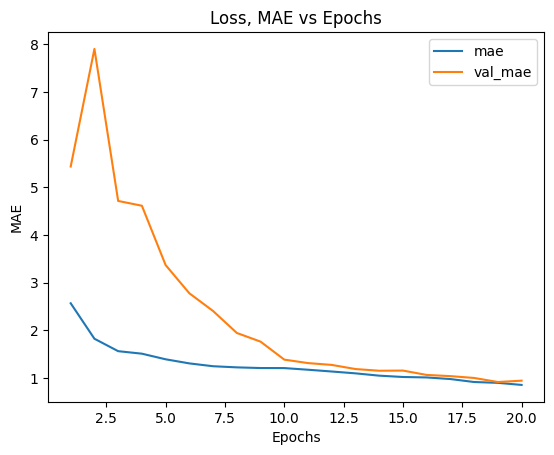

In [50]:
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['mae'], label = 'mae')
plt.plot(epochs, history.history['val_mae'], label = 'val_mae')
plt.title('Loss, MAE vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [51]:
loss, mae = model.evaluate(x_test, y_test)
print('test 1 mae = ', mae)

6/6 [==============================] - 0s 3ms/step - loss: 2.3313 - mae: 0.9668
test 1 mae =  0.9668416380882263


In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30)               120       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 10)                310       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 551
Trainable params: 491
Non-trainable params: 60
_________________________________________________________________


## Hyperband

In [52]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(x.shape[1],)))
    model.add(BatchNormalization())
    for i in range(hp.Int("num_layers", min_value=1, max_value=3)):
      model.add(Dense(units=hp.Int("units_" + str(i), min_value=10, max_value=50, step=1),
                      activation=hp.Choice("activation", values=['relu', 'elu', 'selu','tanh'])))
      model.add(Dropout(hp.Float("dropout_" + str(i), 0, 0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))

    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling ='log')),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

In [53]:
# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective="val_mae",
                     max_epochs=81,
                     factor=3,
                     directory="kt_dir",
                     project_name="kt_hyperband",
                     seed = 101)

# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 50, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu', 'tanh'], 'ordered': False}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [54]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,
                                              min_delta = 0.001, restore_best_weights=True)

tuner.search(x_train, y_train, epochs=20, validation_data=(x_valid,y_valid),
             batch_size=512, callbacks=[early_stop], verbose=2)

Trial 211 Complete [00h 00m 03s]
val_mae: 1.7638999223709106

Best val_mae So Far: 0.6692638993263245
Total elapsed time: 00h 13m 25s


In [58]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]
print(best_hps.get('units_0'))
print(best_hps.get('units_1'))
print(best_hps.get('units_2'))
print(best_hps.get('lr'))
print(best_hps.get('num_layers'))
print(best_hps.get('activation'))
print(best_hps.get('dropout_0'))
print(best_hps.get('dropout_1'))
print(best_hps.get('dropout_2'))

13
32
25
0.009864796448312292
3
tanh
0.30000000000000004
0.4
0.0


In [56]:
best_model = tuner.get_best_models()[0]
print(best_model.evaluate(x_test, y_test))

6/6 [==============================] - 0s 6ms/step - loss: 1.0584 - mae: 0.7042
[1.0584207773208618, 0.7042181491851807]


In [57]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30)               120       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 13)                403       
                                                                 
 dropout (Dropout)           (None, 13)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                448       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                825       
                                                        